In [87]:
# Load libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns



In [78]:
# Read the dataset 
dataFile = "data/Shining32.csv"
data = pd.read_csv(dataFile)
data.head()

,buyerid,age,education,inc,gender,location,purchase,brandid,mint,white,fluoride,kids,size,discount,familypack,priceperoz,priceperpack,Chosen,SecondChoice
0,1,56,College,79523.203,Female,Brooklyn,Online,Colgate,Yes,Yes,No,No,4.8,1,0,0.92,4.42,0,NaN
1,1,56,College,79523.203,Female,Brooklyn,Online,Colgate,Yes,No,Yes,No,3.9,0,1,0.96,3.74,1,NaN
2,1,56,College,79523.203,Female,Brooklyn,Online,Colgate,No,Yes,Yes,Yes,3.9,1,0,1.04,4.06,0,NaN
3,1,56,College,79523.203,Female,Brooklyn,Online,Crest,Yes,Yes,No,No,4.8,1,0,0.92,4.42,0,NaN
4,1,56,College,79523.203,Female,Brooklyn,Online,Crest,No,No,Yes,Yes,4.8,1,0,1.01,4.85,0,NaN


In [79]:
# Processing

# Convert yes/no to 1/0
dict  = {"Yes" : 1, "No" : 0}
data.replace({"mint": dict,"white": dict,"fluoride": dict, "kids": dict},inplace=True)

# Define product id
uniqueProducts  = data.groupby(['brandid','mint','white','fluoride','kids']).size().reset_index().rename(columns={0:'count'})
data["productId"] = 0
for i in range(10):
    data.iloc[(data.brandid == uniqueProducts.iloc[i,0]) & 
        (data.mint == uniqueProducts.iloc[i,1]) &
        (data.white == uniqueProducts.iloc[i,2]) &
        (data.fluoride == uniqueProducts.iloc[i,3]) &
        (data.kids == uniqueProducts.iloc[i,4]),-1] = i + 1

# Add dummies
data = data.join(pd.get_dummies(data.education,prefix="ed"))
data = data.join(pd.get_dummies(data.location,prefix="loc"))
data = data.join(pd.get_dummies(data.gender,prefix="gen"))
data = data.join(pd.get_dummies(data.purchase,prefix="purchase"))
data = data.join(pd.get_dummies(data.brandid,prefix="brand"))

# Rename some columns
data = data.rename({'ed_High School':'ed_HighSchool', 'ed_More than College':'ed_MoreCollege',
     'purchase_In Store':'purchase_InStore'}, axis='columns')

data.head(12)

,buyerid,age,education,inc,gender,location,purchase,brandid,mint,white,...,loc_Queens,gen_Female,gen_Male,gen_Other,purchase_InStore,purchase_Online,brand_Aquafresh,brand_Colgate,brand_Crest,brand_Sensodyne
0,1,56,College,79523.203,Female,Brooklyn,Online,Colgate,1,1,...,0,1,0,0,0,1,0,1,0,0
1,1,56,College,79523.203,Female,Brooklyn,Online,Colgate,1,0,...,0,1,0,0,0,1,0,1,0,0
2,1,56,College,79523.203,Female,Brooklyn,Online,Colgate,0,1,...,0,1,0,0,0,1,0,1,0,0
3,1,56,College,79523.203,Female,Brooklyn,Online,Crest,1,1,...,0,1,0,0,0,1,0,0,1,0
4,1,56,College,79523.203,Female,Brooklyn,Online,Crest,0,0,...,0,1,0,0,0,1,0,0,1,0
5,1,56,College,79523.203,Female,Brooklyn,Online,Sensodyne,1,0,...,0,1,0,0,0,1,0,0,0,1
6,1,56,College,79523.203,Female,Brooklyn,Online,Sensodyne,0,1,...,0,1,0,0,0,1,0,0,0,1
7,1,56,College,79523.203,Female,Brooklyn,Online,Aquafresh,1,0,...,0,1,0,0,0,1,1,0,0,0
8,1,56,College,79523.203,Female,Brooklyn,Online,Aquafresh,0,1,...,0,1,0,0,0,1,1,0,0,0
9,1,56,College,79523.203,Female,Brooklyn,Online,Aquafresh,0,1,...,0,1,0,0,0,1,1,0,0,0


## Generate graphs for Part II

g:\My Drive\Columbia_doc\My Classes\IO II\Problem sets\ps2_IO2\.venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
g:\My Drive\Columbia_doc\My Classes\IO II\Problem sets\ps2_IO2\.venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


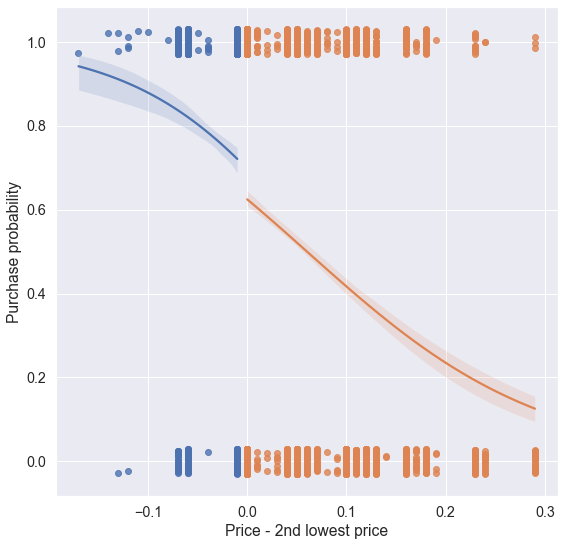

In [88]:
# graph in store/ pricer per oz
data_1 = data[data["purchase"]=="In Store"].copy()
n,k = data_1.shape
J = 10
ni = n//J

Y = np.expand_dims(data_1["Chosen"].to_numpy(),axis=1)
Y = data_1["Chosen"].to_numpy()
p = np.expand_dims(data_1["priceperoz"].to_numpy(),axis=1)

# separate by consumer


p = p.reshape((J,ni),order='F')
Y = Y.reshape((J,ni),order='F')

p = p - np.partition(p, 1,axis=0)[1]

# choose product
j = 1
p = p[j,:]
Y = Y[j,:]

# reshape

Y = Y.reshape((ni,),order='F')
p = p.reshape((ni,),order='F')

# 
p_neg = p[np.where(p<0)]
Y_neg = Y[np.where(p<0)]

p_pos = p[np.where(p>=0)]
Y_pos = Y[np.where(p>=0)]

# Initialize layout
fig, ax = plt.subplots(figsize = (9, 9))

# Add scatterplot
#ax.scatter(p, Y, s=60, alpha=0.7, edgecolors="k")
sns.set(font_scale=1.3)
sns.regplot(p_neg, Y_neg, logistic=True, n_boot=50, y_jitter=.03,ax=ax)
sns.regplot(p_pos, Y_pos, logistic=True, n_boot=50, y_jitter=.03,ax=ax)
ax.set(xlabel='Price - 2nd lowest price', ylabel='Purchase probability')
plt.show()


g:\My Drive\Columbia_doc\My Classes\IO II\Problem sets\ps2_IO2\.venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
g:\My Drive\Columbia_doc\My Classes\IO II\Problem sets\ps2_IO2\.venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


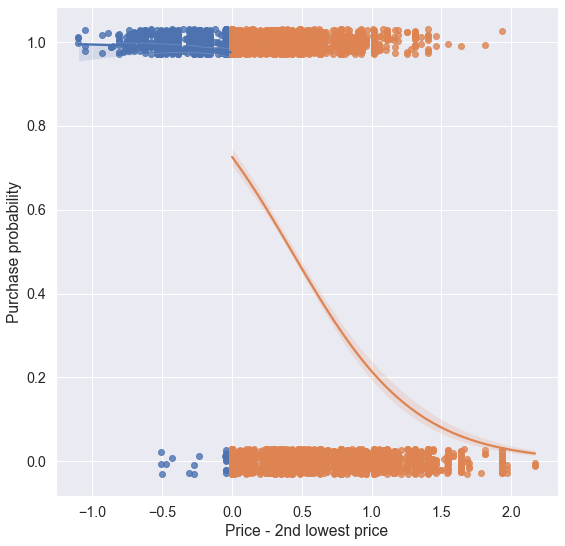

In [93]:
# Using price per pack

p = np.expand_dims(data_1["priceperpack"].to_numpy(),axis=1)
p = p.reshape((J,ni),order='F')
p = p - np.partition(p, 1,axis=0)[1]

# choose product
j = 1
p = p[j,:]

# reshape
p = p.reshape((ni,),order='F')

# 
p_neg = p[np.where(p<0)]
Y_neg = Y[np.where(p<0)]

p_pos = p[np.where(p>=0)]
Y_pos = Y[np.where(p>=0)]

# Initialize layout
fig, ax = plt.subplots(figsize = (9, 9))

# Add scatterplot
#ax.scatter(p, Y, s=60, alpha=0.7, edgecolors="k")
sns.set(font_scale=1.3)
sns.regplot(p_neg, Y_neg, logistic=True, n_boot=50, y_jitter=.03,ax=ax)
sns.regplot(p_pos, Y_pos, logistic=True, n_boot=50, y_jitter=.03,ax=ax)
ax.set(xlabel='Price - 2nd lowest price', ylabel='Purchase probability')
plt.show()

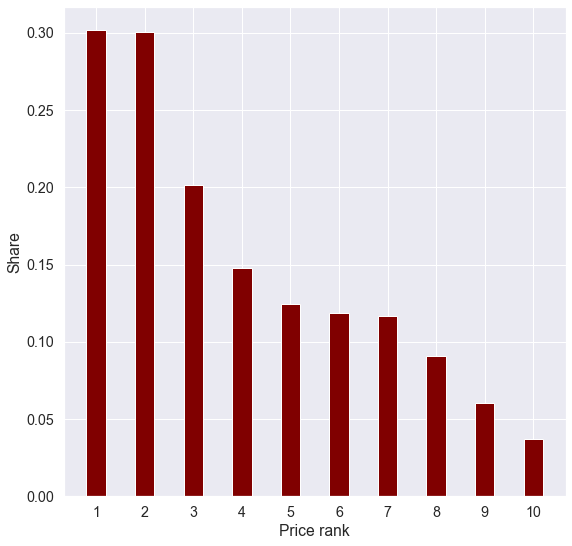

In [172]:
# graph 
data_2 = data[data["purchase"]=="Online"].copy()
n,k = data_2.shape
J = 10
ni = n//J

Y = np.expand_dims(data_2["Chosen"].to_numpy(),axis=1)
Y = data_2["Chosen"].to_numpy()
p = np.expand_dims(data_2["priceperoz"].to_numpy(),axis=1)

# separate by consumer
p = p.reshape((J,ni),order='F')
Y = Y.reshape((J,ni),order='F')

# pick N

share_p_rank = np.zeros((J,))

for N in range(J):
    pi = p - np.partition(p, N,axis=0)[N]

    choice = choice = ((pi[np.where(Y==1)[0],np.arange(ni)]==0)).astype(int).sum()

    share_p_rank[N] = choice


share_p_rank = share_p_rank/ni

# Initialize layout
fig, ax = plt.subplots(figsize = (9, 9))

plt.bar(np.arange(1,J+1), share_p_rank, color ='maroon',
        width = 0.4)
plt.xticks(np.arange(1,J+1))
ax.set(xlabel='Price rank', ylabel='Share')
plt.show()


## Generate Tables for Part I

In [4]:
dictBorough = {"Brooklyn": 1, "Manhattan": 2, "Queens": 3, "Other":4}
data["market"] = data["location"].map(dictBorough)
data.head(20)

,buyerid,age,education,inc,gender,location,purchase,brandid,mint,white,...,gen_Female,gen_Male,gen_Other,purchase_InStore,purchase_Online,brand_Aquafresh,brand_Colgate,brand_Crest,brand_Sensodyne,market
0,1,56,College,79523.203,Female,Brooklyn,Online,Colgate,1,1,...,1,0,0,0,1,0,1,0,0,1
1,1,56,College,79523.203,Female,Brooklyn,Online,Colgate,1,0,...,1,0,0,0,1,0,1,0,0,1
2,1,56,College,79523.203,Female,Brooklyn,Online,Colgate,0,1,...,1,0,0,0,1,0,1,0,0,1
3,1,56,College,79523.203,Female,Brooklyn,Online,Crest,1,1,...,1,0,0,0,1,0,0,1,0,1
4,1,56,College,79523.203,Female,Brooklyn,Online,Crest,0,0,...,1,0,0,0,1,0,0,1,0,1
5,1,56,College,79523.203,Female,Brooklyn,Online,Sensodyne,1,0,...,1,0,0,0,1,0,0,0,1,1
6,1,56,College,79523.203,Female,Brooklyn,Online,Sensodyne,0,1,...,1,0,0,0,1,0,0,0,1,1
7,1,56,College,79523.203,Female,Brooklyn,Online,Aquafresh,1,0,...,1,0,0,0,1,1,0,0,0,1
8,1,56,College,79523.203,Female,Brooklyn,Online,Aquafresh,0,1,...,1,0,0,0,1,1,0,0,0,1
9,1,56,College,79523.203,Female,Brooklyn,Online,Aquafresh,0,1,...,1,0,0,0,1,1,0,0,0,1


In [5]:
# Fit some logit models to explain chosen product characteristcs

# Restrict the dataset to the chosen prodicts
dataChosen = data[data['Chosen'] == 1].copy()

# Normalization
dataChosen["sizeNorm"] = np.divide(dataChosen["size"]-np.min(dataChosen["size"]),
                                np.max(dataChosen["size"])-np.min(dataChosen["size"]))
dataChosen["inc"] = dataChosen["inc"]/1000

# Regressors = consumer attributes
regressors  = '~ age + inc + ed_College + ed_MoreCollege +'\
                'loc_Brooklyn + loc_Manhattan + loc_Other +'\
                'gen_Female + gen_Other + purchase_InStore'

# Predict the chosen brand
mBrand_1 = smf.logit('brand_Colgate'+regressors, data=dataChosen).fit()
mBrand_2 = smf.logit('brand_Aquafresh'+regressors, data=dataChosen).fit()
mBrand_3 = smf.logit('brand_Sensodyne'+regressors, data=dataChosen).fit()
mBrand_4 = smf.logit('brand_Crest'+regressors, data=dataChosen).fit()

# Predict other chosen characteristics
mChrc_1 = smf.logit('mint'+regressors, data=dataChosen).fit()
mChrc_2 = smf.logit('white'+regressors, data=dataChosen).fit()
mChrc_3 = smf.logit('fluoride'+regressors, data=dataChosen).fit()
mChrc_4 = smf.logit('kids'+regressors, data=dataChosen).fit()
mChrc_5 = smf.logit('sizeNorm'+regressors, data=dataChosen).fit()
mChrc_6 = smf.logit('discount'+regressors, data=dataChosen).fit()
mChrc_7 = smf.logit('familypack'+regressors, data=dataChosen).fit()
mChrc_8 = smf.ols('priceperoz'+regressors, data=dataChosen).fit()

Optimization terminated successfully.
         Current function value: 0.598719
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.377925
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.313782
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.237058
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.154480
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.537584
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.618602
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.079393
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.565306
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.342223
  

In [73]:
dataChosen2 = data[~np.isnan(data['SecondChoice'])].copy()



characteristics = ['brand_Colgate', 'brand_Aquafresh', 'brand_Sensodyne', 
        'brand_Crest', 'mint', 'white', 'fluoride',
        'kids', 'size', 'discount', 'familypack', 'priceperoz',
        'priceperpack']
dataChosen2 = dataChosen2[['buyerid','Chosen','SecondChoice']+characteristics]

# normalize
data_norm = data[characteristics].copy()

means = np.expand_dims(data_norm.to_numpy().mean(axis=0),axis=0)
sds = np.expand_dims(data_norm.to_numpy().std(axis=0),axis=0)

norm_data = (dataChosen2[characteristics].to_numpy() - means)/sds

dataChosen2[characteristics] = norm_data
         

firstChoice = dataChosen2[dataChosen2["Chosen"]>0]
secondChoice = dataChosen2[dataChosen2["SecondChoice"]>0]

corr = []
pval = []
prod = []
for i in range(len(characteristics)):
    ch = characteristics[i]
    corr.append(np.round(np.corrcoef(firstChoice[ch].to_numpy(),
                    secondChoice[ch].to_numpy())[0,1],4))
    pval.append(np.round(pearsonr(firstChoice[ch].to_numpy(),
                    secondChoice[ch].to_numpy())[1],4))
    prod.append(np.round(
                      (firstChoice[ch].to_numpy()*\
                      secondChoice[ch].to_numpy()).mean()  ,4
                    )
                    )    
correlations = pd.DataFrame({'Characteristic': characteristics,
                            'Correlation': corr,
                            'p-value': pval,
                            'prod': prod})
correlations = correlations.sort_values(by='prod')
correlations

,Characteristic,Correlation,p-value,prod
6,fluoride,-0.2557,0.0000,-0.3033
2,brand_Sensodyne,-0.1466,0.0009,-0.0753
1,brand_Aquafresh,-0.0980,0.0267,-0.0262
3,brand_Crest,-0.0436,0.3250,0.0323
10,familypack,0.0053,0.9041,0.0434
9,discount,0.0473,0.2861,0.0590
5,white,-0.0990,0.0252,0.1155
0,brand_Colgate,-0.1106,0.0123,0.1844
7,kids,-0.0149,0.7367,0.3782
8,size,0.1080,0.0146,0.4075


In [52]:
firstChoice.head()

,buyerid,Chosen,SecondChoice,brand_Colgate,brand_Aquafresh,brand_Sensodyne,brand_Crest,mint,white,fluoride,kids,size,discount,familypack,priceperoz,priceperpack
19,2,1,0.0,0,1,0,0,0,1,0,0,3.9,1,1,0.86,3.35
127,13,1,0.0,0,1,0,0,1,0,1,0,3.9,1,0,0.91,3.55
170,18,1,0.0,1,0,0,0,1,1,0,0,3.9,1,1,0.86,3.35
610,62,1,0.0,1,0,0,0,1,1,0,0,3.9,1,1,0.86,3.35
641,65,1,0.0,1,0,0,0,1,0,1,0,4.8,1,1,0.85,4.08


In [53]:
secondChoice.head()

,buyerid,Chosen,SecondChoice,brand_Colgate,brand_Aquafresh,brand_Sensodyne,brand_Crest,mint,white,fluoride,kids,size,discount,familypack,priceperoz,priceperpack
10,2,0,1.0,1,0,0,0,1,1,0,0,3.9,0,0,1.03,4.02
125,13,0,1.0,0,0,1,0,1,0,0,0,3.9,1,0,1.04,4.06
174,18,0,1.0,0,0,0,1,0,0,1,1,3.9,1,1,0.95,3.71
615,62,0,1.0,0,0,1,0,1,0,0,0,3.9,1,1,0.98,3.82
647,65,0,1.0,0,1,0,0,1,0,1,0,3.9,1,0,0.91,3.55


In [25]:
resultsAlll = summary_col( [mBrand_1,mBrand_2,mBrand_3,mBrand_4]+
    [mChrc_1,mChrc_2,mChrc_3,mChrc_4,mChrc_5,mChrc_6,mChrc_7,mChrc_8],stars=True)
print(resultsAlll)


                 brand_Colgate brand_Aquafresh brand_Sensodyne brand_Crest    mint      white     fluoride    kids    sizeNorm   discount  familypack priceperoz
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept        0.1102        -1.7976***      -1.6076***      -1.3702**   3.4020***  0.2520     -0.7704** -2.5050** -1.9591*** 3.4508***  0.3148     0.9023*** 
                 (0.3484)      (0.4805)        (0.5336)        (0.6373)    (0.8259)   (0.3716)   (0.3395)  (1.2395)  (0.3656)   (0.5132)   (0.3204)   (0.0101)  
R-squared                                                                                                                                             0.0016    
R-squared Adj.                                                                                                                                        0.0006    
age              0.0093        -0

In [27]:
print(resultsAlll.as_latex())

\begin{table}
\caption{}
\label{}
\begin{center}
\begin{tabular}{lllllllllllll}
\hline
                  & brand\_Colgate & brand\_Aquafresh & brand\_Sensodyne & brand\_Crest & mint       & white      & fluoride  & kids      & sizeNorm   & discount   & familypack & priceperoz  \\
\hline
Intercept         & 0.1102         & -1.7976***       & -1.6076***       & -1.3702**    & 3.4020***  & 0.2520     & -0.7704** & -2.5050** & -1.9591*** & 3.4508***  & 0.3148     & 0.9023***   \\
                  & (0.3484)       & (0.4805)         & (0.5336)         & (0.6373)     & (0.8259)   & (0.3716)   & (0.3395)  & (1.2395)  & (0.3656)   & (0.5132)   & (0.3204)   & (0.0101)    \\
R-squared         &                &                  &                  &              &            &            &           &           &            &            &            & 0.0016      \\
R-squared Adj.    &                &                  &                  &              &            &            &           &   

: 